In [1]:
use_model = "ews_gpt35"
# Choose embedding method
model_embed = "bert"

In [2]:
import numpy as np
import tqdm
import random
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import jaconv
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import networkx as nx
import unicodedata

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
log_list = glob.glob(use_model + "/*")

In [4]:
def read_log(path):
    with open(path, "r") as f:
        lines = f.readlines()

    out_edges = []
    for kkk in range(len(lines)):
        #kkk = 0
        data = json.loads(lines[kkk])
        answer = data["answer"]
                
        date = data["date"]
        now_future = data["type"]
        v1 = data["input"].split(";")
        label = v1[0]
        region = v1[1]
        industry = v1[2]

        try:
            if answer.startswith('```json'):
                # Strip the markdown code block indicators
                answer = answer.strip('```json\\n')
                # Load the inner JSON
                answer_dict = json.loads(answer)
                nodes = answer_dict['ノードリスト']
                edges = answer_dict['エッジリスト']
                #### ADDED ####
                edges = list(edges)
                ###############

                for j in range(len(edges)):
                    try:
                        if "-->" in edges[j]:
                            tmp = edges[j].split("-->")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"cause",tmp[1]])
                        else:
                            tmp = edges[j].split("--*")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"nin",tmp[1]])
                    except:
                        pass
                    
            elif "\n}\n}" in answer:
                answer = answer.replace("\n}\n}","]\n}")
                answer_dict = json.loads(answer)

                nodes = answer_dict['ノードリスト']
                edges = answer_dict['エッジリスト']
                #### ADDED ####
                edges = list(edges)
                ###############
                
                for j in range(len(edges)):
                    try:
                        if "-->" in edges[j]:
                            tmp = edges[j].split("-->")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"cause",tmp[1]])
                        else:
                            tmp = edges[j].split("--*")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"nin",tmp[1]])
                    except:
                        pass      
                      
            else:
                #print("yes")
                answer_dict = json.loads(answer)

                nodes = answer_dict['ノードリスト']
                edges = answer_dict['エッジリスト']
                #### ADDED ####
                edges = list(edges)
                ###############
                
                for j in range(len(edges)):
                    try:
                        if "-->" in edges[j]:
                            tmp = edges[j].split("-->")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"cause",tmp[1]])
                        else:
                            tmp = edges[j].split("--*")
                            out_edges.append([date,region,industry,label,now_future,tmp[0],"nin",tmp[1]])
                    except:
                        pass
        except:
            print(kkk)
    return out_edges


def convert_numbers(df):
    # Function to check if the value is numeric (float or int)
    def is_number(x):
        try:
            float(x)  # Type-casting to float to check for numeric
            return True
        except ValueError:
            return False

    # Applymap to check each element if it's numeric and then convert
    df["source"] = df["source"].apply(lambda x: str(int(float(x))) if is_number(x) else x)
    df["target"] = df["target"].apply(lambda x: str(int(float(x))) if is_number(x) else x)

    return df


def convert_full_width_numeral_to_half_width(element):
    if isinstance(element, str):
        # Normalize element to half-width if it contains full-width numerals
        return ''.join(unicodedata.normalize('NFKC', char) if '\uff10' <= char <= '\uff19' else char for char in element)
    return element


import pandas as pd
import networkx as nx

def filter_top_nodes(edgelist_df, top_n=100):
    # Gather all unique nodes from both source and target columns
    all_nodes = pd.concat([edgelist_df['source'], edgelist_df['target']]).unique()

    # Calculate incoming and outgoing degrees
    node_in = edgelist_df['target'].value_counts()
    node_out = edgelist_df['source'].value_counts()

    # Ensure all nodes are represented in both incoming and outgoing counts
    node_in = node_in.reindex(all_nodes, fill_value=0)
    node_out = node_out.reindex(all_nodes, fill_value=0)
    
    # Define the conditions for filtering nodes
    cond_more_than_four_in = node_in > 19
    cond_at_least_one_in_and_out = (node_in >= 1) & (node_out >= 1)

    # Combine conditions to find the relevant nodes
    valid_nodes = node_in[cond_more_than_four_in | cond_at_least_one_in_and_out].index

    # Get the top N nodes based on the conditions, or all if fewer than top_n
    if top_n < 1 or top_n > len(valid_nodes):
        top_nodes = valid_nodes
    else:
        top_nodes = valid_nodes[:top_n]  # Adjust this if you want to sort or apply a different criteria

    # Filter the DataFrame to include only edges with both nodes in the top nodes
    filtered_df = edgelist_df[(edgelist_df['source'].isin(top_nodes)) & (edgelist_df['target'].isin(top_nodes))]

    # Create a graph from the filtered edge list
    G = nx.from_pandas_edgelist(filtered_df, 'source', 'target')

    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)

    # Filter the DataFrame again to keep only edges within the largest connected component
    largest_cc_df = filtered_df[(filtered_df['source'].isin(largest_cc)) & (filtered_df['target'].isin(largest_cc))]

    return largest_cc_df, largest_cc

In [5]:
list_df = []
for i in range(len(log_list)):
    path = log_list[i]
    out_edges = read_log(path)
    df_edges = pd.DataFrame(out_edges)
    df_edges.columns = ["date","region","industry","label","type","source","relation","target"]
    df_edges["date"] = pd.to_datetime(df_edges["date"])
    list_df.append(df_edges)
    
df_edges = pd.concat(list_df)
print("Loaded: " + str(len(df_edges)))

df_edges["source"] = df_edges["source"].astype(str)
df_edges["target"] = df_edges["target"].astype(str)

1802
Loaded: 6122


Filter edge list

In [6]:
list_df = []
for i in range(len(log_list)):
    path = log_list[i]
    out_edges = read_log(path)
    df_edges = pd.DataFrame(out_edges)
    df_edges.columns = ["date","region","industry","label","type","source","relation","target"]
    df_edges["date"] = pd.to_datetime(df_edges["date"])
    list_df.append(df_edges)
    
df_edges = pd.concat(list_df)
print("What we loaded: " + str(len(df_edges)))

df_edges["source"] = df_edges["source"].astype(str)
df_edges["target"] = df_edges["target"].astype(str)

df_edges = df_edges.applymap(convert_full_width_numeral_to_half_width)


cond = (df_edges["source"] != "0") & (df_edges["source"] != "1") & (df_edges["source"] != "2") \
   & (df_edges["source"] != "3") & (df_edges["source"] != "4") & (df_edges["source"] != "5") \
   & (df_edges["source"] != "6") & (df_edges["source"] != "7") & (df_edges["source"] != "8") \
   & (df_edges["source"] != "9") & (df_edges["target"] != "0") & (df_edges["target"] != "6") \
   & (df_edges["target"] != "7") & (df_edges["target"] != "8") & (df_edges["target"] != "9") \
   & (df_edges["source"] != "") & (df_edges["target"] != "") & (df_edges["source"] != df_edges["target"])

df_edges = df_edges.loc[cond].copy()

modify2new = dict()
modify2new.update({"景気判断1":"1","景気判断2":"2","景気判断3":"3","景気判断4":"4","景気判断5":"5"})

df_edges["source"] = df_edges["source"].map(modify2new).fillna(df_edges["source"])
df_edges["target"] = df_edges["target"].map(modify2new).fillna(df_edges["target"])

print("After filter: " + str(len(df_edges)))

1802
What we loaded: 6122
After filter: 6101


/var/folders/xn/9jbxxjcj63b3xbh21qlt_pcr0000gn/T/ipykernel_5551/1238650981.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_edges = df_edges.applymap(convert_full_width_numeral_to_half_width)


Basic analysis

In [7]:
# Tree numbers as numbers
df_edges["relation"].value_counts()

relation
cause    5108
nin       993
Name: count, dtype: int64

In [8]:
df_edges["type"].value_counts()

type
now       3342
future    2759
Name: count, dtype: int64

Plot time series edge

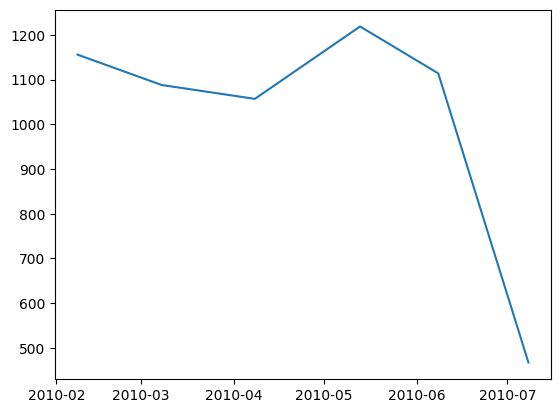

In [9]:
df_date = pd.DataFrame(df_edges["date"].value_counts())
df_date.reset_index(inplace=True)
df_date.sort_values(by="date",inplace=True)
plt.plot(df_date["date"],df_date["count"])

Phrase Embedding

In [11]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.3/392.3 kB 6.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
# THIS MODEL MIGHT NOT BE SUITABLE FOR PYTHON 3.10 and LATER
if model_embed == "use":
    
    import tensorflow
    import tensorflow_hub as hub
    import tensorflow_text
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
    
else:
    
    from transformers import BertModel, BertTokenizer
    import torch

    def load_model_and_tokenizer():
        # Load tokenizer and model from Hugging Face Hub
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        model = BertModel.from_pretrained('bert-base-multilingual-cased')
        return tokenizer, model

    def get_embeddings(texts, tokenizer, model):
        # Tokenize input texts and prepare input tensors
        encoded_input = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        # Move tensors to the same device as the model
        input_ids = encoded_input['input_ids']

        with torch.no_grad():  # Do not compute gradients
            # Forward pass, get hidden states
            output = model(input_ids)
            # We take the embeddings from the last hidden state
            embeddings = output.last_hidden_state[:, 0, :]
        return embeddings

    tokenizer, model = load_model_and_tokenizer()
    # Get embeddings

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create Node List

In [13]:
nodes = list(set(df_edges["source"]))
nodes.extend(list(set(df_edges["target"])))
nodes = list(set(nodes))

In [14]:
if model_embed == "use":
    # USE
    #num_bunkatsu = 1000
    #list_nodes = []
    #for i in range(int( len(nodes) / num_bunkatsu) + 1):
    #    start = i*num_bunkatsu
    #    owari = (i+1)*num_bunkatsu
    #    #print(start,owari)
    #    list_nodes.append(embed(nodes[start:owari]))
    #nodes_emb = np.concatenate(list_nodes)    
    start = 0
    owari = 1000
    nodes_emb = embed(nodes[start:owari])

else:
    # BERT
    #nodes_emb = get_embeddings(nodes, tokenizer, model)
    start = 0
    owari = 1000
    nodes_emb = get_embeddings(nodes[start:owari], tokenizer, model)    

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


DBSCAN

In [15]:
%%time
## Hyper parameters
if model_embed == "use":
    eps = 0.45
    min_samples= 2
else:
    eps = 3.5
    min_samples= 2
    
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(nodes_emb) # debug

CPU times: user 283 ms, sys: 97.9 ms, total: 381 ms
Wall time: 243 ms


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [16]:
# Restrict to clusters that are not treated as outliers (-1)
df_nodes = pd.DataFrame({"node":nodes[start:owari],"label":clustering.labels_})
# Find representative node name
df_nodes.sort_values(by="label",ascending=True,inplace=True)

In [17]:
set(df_nodes["label"])

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [18]:
cond = df_nodes["label"] == 4
df_tmp = df_nodes.loc[cond].copy()
df_tmp

,node,label
76,新築物件の注文減少,4
935,新築の件数大幅減少,4
